In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image as image_utils



In [2]:

ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
SIZE = (224, 224, 3)
# Create the base model from the pre-trained model MobileNet V2 which is trained on imagenet Dataset
# which consists of 1.2M labelled images.
imagenet = tf.keras.applications.MobileNetV2(input_shape=SIZE,
                                               include_top=False,
                                               weights='imagenet')
#To tell Tf not to adjust weigths of imagenet model which are already trained
imagenet.trainable = False
#model Summary
imagenet.summary()
#Defining New Model with imagenet as the Base Model using Sequential Api
model = tf.keras.models.Sequential([
    imagenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])
#Using ImageDataGenerator to ease Data preparation as it lables images based on Folder Name which is ideal for the way Data Set is arranged
TRAINING_DIR = "dataset/train_images/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(224, 224))

VALIDATION_DIR = "dataset/test_images/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(224, 224))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(train_generator,
                              epochs=5,
                              verbose=1,
                              validation_data=validation_generator)


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

<Figure size 432x288 with 0 Axes>

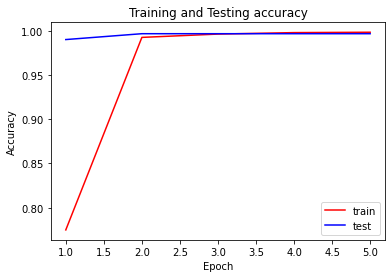

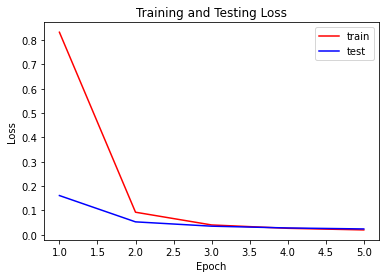

<Figure size 432x288 with 0 Axes>

In [3]:
#Saving Model for future Predictions
model.save('TLmodel.h5')
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,6) # Get number of epochs
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Testing accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.figure()
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.legend(['train', 'test'], loc='upper right')
plt.title('Training and Testing Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.figure()
# Desired output. Charts with training and validation metrics. No crash :)


In [5]:
classes = ["Airplanes","Bonsai","Butterfly","Car_side","Faces","ketch","Leopards","Motorbikes","Scorpion","Watch"]
class_indices
print(classes)

['Airplanes', 'Bonsai', 'Butterfly', 'Car_side', 'Faces', 'ketch', 'Leopards', 'Motorbikes', 'Scorpion', 'Watch']


Found 604 images belonging to 10 classes.
7/7 [==============================] - 29s 4s/step
No of errors = 2/604
Predicted class: 7
Predicted label: motorbikes


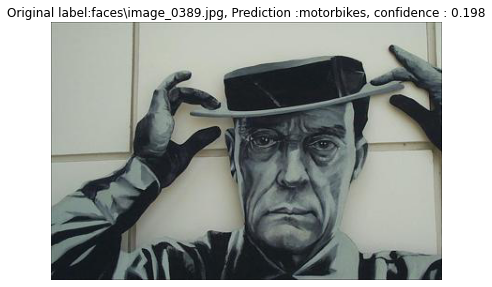

Predicted class: 9
Predicted label: watch


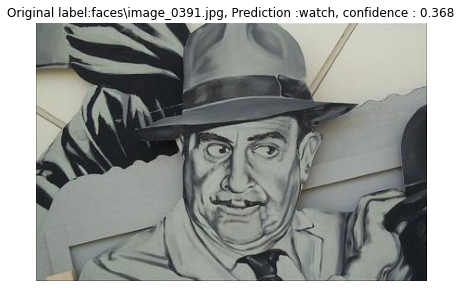

In [20]:
# Create a generator for prediction
tag_size =(224,224)
validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=tag_size,
        batch_size=100,
        class_mode='categorical',
        shuffle=False)
# Get the filenames from the generator
fnames = validation_generator.filenames

ground_truth = validation_generator.classes
label2index = validation_generator.class_indices
idx2label = dict((v,k) for k,v in label2index.items())
       
# Get the predictions from the model using the generator
predictions = model.predict(validation_generator,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    print("Predicted class:",pred_class)
    pred_label = idx2label[pred_class]
    print("Predicted label:",pred_label)
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
    
    original = load_img('{}/{}'.format(VALIDATION_DIR,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()
    label2index = validation_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

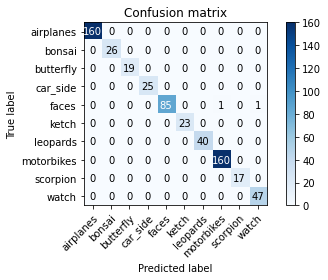

In [25]:
from sklearn.metrics import confusion_matrix
def PlotConfusionMatrix(ground_truth, predicted_classes):
    np.set_printoptions(precision=2)
    classes = ['airplanes','bonsai','butterfly','car_side','faces','ketch','leopards','motorbikes','scorpion','watch']
    title='Confusion matrix'
    cmap=plt.cm.Blues
    cm = confusion_matrix(ground_truth,predicted_classes)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fmt ='d' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j],fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()    
    plt.show()
PlotConfusionMatrix(ground_truth, predicted_classes)